#### Nguyên lý đơn giản: Generator sẽ cố gắng tạo ra 1 ảnh để đánh lừa Discriminator còn Discriminator sẽ cố gắng phân biệt ảnh đấy đấy là thật hay được tạo ra, đồng thời nói cho Generator là vì sao nó biết là giả, cả 2 bộ phận này tiếp tục được học cho đến khi cả 2 đều có khả năng tốt nhất (đạt trạng thái cân bằng Nash)
* Các ký hiệu:
    * $G$: Generator
    * $D$: Discriminator
    * $z$: noise đầu vào của Generator
    * $x$: dữ liệu thật từ bộ dataset
    * $G(z)$ là ảnh được sinh ra từ Generator
    * $D(x)$ là giá trị dự đoán của Discriminator xem ảnh $x$ là thật hay không
    * $D(G(z))$ là giá trị dự đoán của Discriminator xem ảnh sinh ra từ Generator là thật hay không
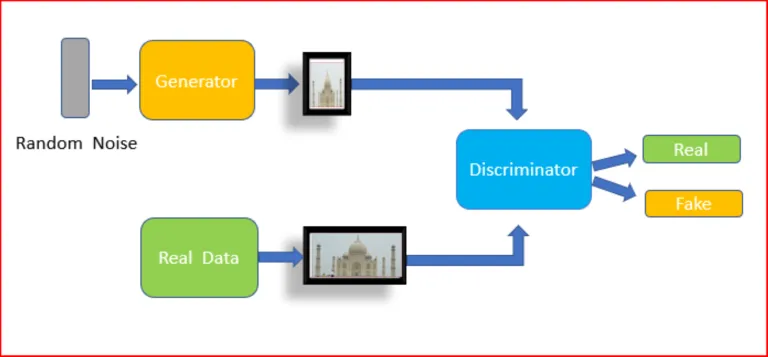
* Vì ta có 2 mạng Generator và Discriminator với mục tiêu khác nhau, nên cần thiết kế 2 loss function cho mỗi mạng
    * Discriminator cố gắng phân biệt đâu là ảnh thật và đâu là ảnh giả
    > $\Rightarrow$ bài toán binary classification nên loss function là **binary cross-entropy loss**
* Output của model đi qua hàm sigmoid nên có gtrị từ 0-1 nên đối vs Discriminator sẽ cố gắng train:
    * Input ảnh ở dataset thì output gần 1 $~~~~~~~~~~~~~~~~~~\Rightarrow D(x)~~~~~~\rightarrow 1$
    * Input là ảnh sinh ra từ Generator thì output gần 0 $\Rightarrow D(G(z)) \rightarrow 0$
* Vì thế ta cần maximize $D(x)$ và minimize $D(G(z))$ hay maximize $(1-D(G(z)))$. Do đó loss function của Discriminator là:
    > $\Large{\displaystyle \max_DV(D)=\underbrace{\mathbb{E}_{x\in p_{data}(x)}[\log D(x)]}_{\text{recognize real images better}}+\underbrace{\mathbb{E}_{z\in p_{z}(z)}[\log (1-D(G(z)))]}_{\text{recognize generated images better}}}$

    > Trong đó $\mathbb{E}$ là kỳ vọng (hiểu là lấy trung bình của tất cả dữ liệu)
* Theo đó, loss function của Generator là:
    > $\Large{\displaystyle \min_GV(G)=\underbrace{\mathbb{E}_{z\in p_{z}(z)}[\log (1-D(G(z)))]}_{\text{optimize to fool Discriminator the most}}}$
    
    > Trong đó $\mathbb{E}$ là kỳ vọng (hiểu là lấy trung bình của tất cả dữ liệu)
* **Cuối cùng, ta viết gộp lại loss của mô hình GAN**:
    > $\Large{\displaystyle \min_G\max_DV(G, D)=\mathbb{E}_{x\in p_{data}(x)}[\log D(x)]+\mathbb{E}_{z\in p_{z}(z)}[\log (1-D(G(z)))]}$
    
    > Trong đó $\mathbb{E}$ là kỳ vọng (hiểu là lấy trung bình của tất cả dữ liệu)
#### Từ hàm loss của GAN có thể thấy là việc train Generator và Discriminator đối nghịch nhau, trong khi D cố gắng maximize loss thì G cố gắng minimize loss. Quá trình train GAN kết thúc khi model GAN đạt đến trạng thái cân bằng của 2 models (gọi là Nash equilibrium)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, math, os
from tensorflow.keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tqdm.notebook import tqdm

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [4]:
# noise vector dimension
z_dim = 100

In [5]:
adam = Adam(learning_rate = 2e-4, beta_1 = 0.5)

# Generator
g = Sequential()
g.add(Dense(256, input_dim = z_dim, activation = LeakyReLU(alpha = 0.2)))
g.add(Dense(512, activation = LeakyReLU(alpha = 0.2)))
g.add(Dense(1024, activation = LeakyReLU(alpha = 0.2)))
g.add(Dense(X_train.shape[1], activation = 'sigmoid'))
g.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Discriminator
d = Sequential()
d.add(Dense(1024, input_dim = X_train.shape[1], activation = LeakyReLU(alpha = 0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation = LeakyReLU(alpha = 0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation = LeakyReLU(alpha = 0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation = 'sigmoid'))
d.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

# Model
d.trainable = False
inputs = Input(shape = (z_dim,))
hidden = g(inputs)
outputs = d(hidden)
gan = Model(inputs, outputs)
gan.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [6]:
def plot_loss(losses, figsize = (10, 8)):
    g_loss = [v[0] for v in losses['G']]
    d_loss = [v[0] for v in losses['D']]
    
    plt.figure(figsize = figsize)
    plt.plot(g_loss, label = 'Generater loss')
    plt.plot(d_loss, label = 'Discriminator loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex = 10, dim = (1, 10), figsize = (12, 2)):
    noise = np.random.normal(0, 1, size = (n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)
    
    plt.figure(figsize = figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'gray_r')
        plt.axis('on')
    plt.tight_layout()
    plt.show()

In [34]:
losses = {'G':[], 'D':[]}

def train(epochs = 100, plt_frq = 10, BATCH_SIZE = 128):
    batch_count = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batch_count)
    
    for e in tqdm(range(1, epochs + 1), desc = 'Progress bar'):
        if e == 1 or e % plt_frq == 0:
            print('-' * 15, 'Epoch %d' % e, '-' * 15)
        for _ in tqdm(range(batch_count), leave = False, desc = 'Epoch %d' % e):
            # Random truth images from dataset
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size = BATCH_SIZE)] # (128, 784)
            # Noise from normal distribution
            noise = np.random.normal(0, 1, size = (BATCH_SIZE, z_dim)) # (128, 100)
            
            # Generator generate images from noise
            generated_images = g.predict(noise) # (128, 784)
            X = np.concatenate((image_batch, generated_images)) # (256, 784)
            # Labeling
            y = np.zeros(2 * BATCH_SIZE) # (256,)
            y[:BATCH_SIZE] = 0.9
            
            # Train Discriminator
            d.trainable = True
            d_loss = d.train_on_batch(X, y)
            
            # Train Generator
            noise = np.random.normal(0, 1, size = (BATCH_SIZE, z_dim))
            # While train Generater, labeling the images that are created by Generator are 1 -> try fool Discriminator
            y2 = np.ones(BATCH_SIZE)
            # Don't update Discriminator weights
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
        
        # Save loss function
        losses['G'].append(g_loss)
        losses['D'].append(d_loss)
        if e == 1 or e % plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


Progress bar:   0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


Epoch 1:   0%|          | 0/468 [00:00<?, ?it/s]

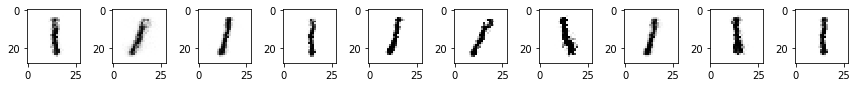

Epoch 2:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 20 ---------------


Epoch 20:   0%|          | 0/468 [00:00<?, ?it/s]

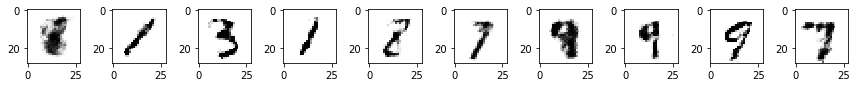

Epoch 21:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 40 ---------------


Epoch 40:   0%|          | 0/468 [00:00<?, ?it/s]

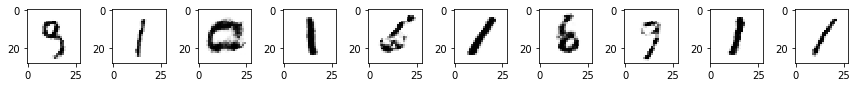

Epoch 41:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 60 ---------------


Epoch 60:   0%|          | 0/468 [00:00<?, ?it/s]

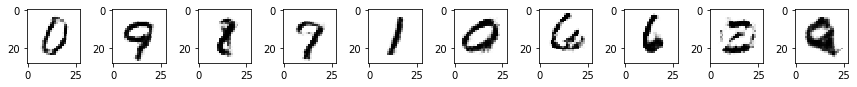

Epoch 61:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 71:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 80 ---------------


Epoch 80:   0%|          | 0/468 [00:00<?, ?it/s]

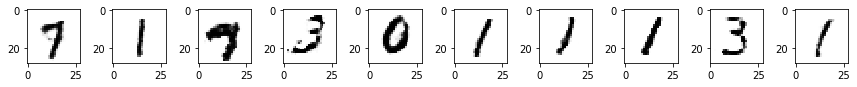

Epoch 81:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 86:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 91:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 92:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 93:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 94:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 95:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 96:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 97:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 98:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 99:   0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 100 ---------------


Epoch 100:   0%|          | 0/468 [00:00<?, ?it/s]

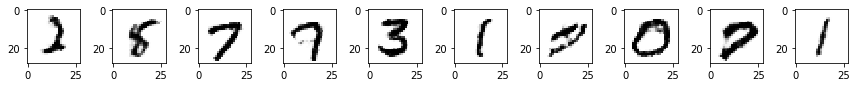

Epoch 101:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 102:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 103:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 104:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 105:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 106:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 107:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 108:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 109:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 110:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 111:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 112:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 113:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 114:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 115:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 116:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 117:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 118:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 119:   0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 120 ---------------


Epoch 120:   0%|          | 0/468 [00:00<?, ?it/s]

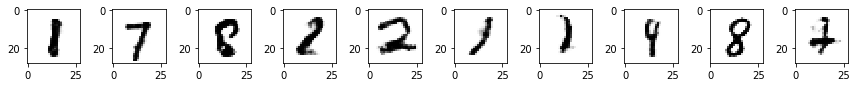

Epoch 121:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 122:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 123:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 124:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 125:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 126:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 127:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 128:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 129:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 130:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 131:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 132:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 133:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 134:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 135:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 136:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 137:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 138:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 139:   0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 140 ---------------


Epoch 140:   0%|          | 0/468 [00:00<?, ?it/s]

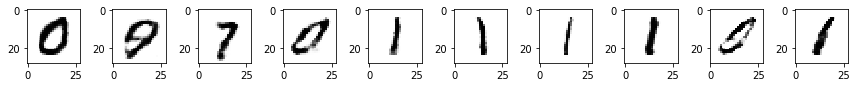

Epoch 141:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 142:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 143:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 144:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 145:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 146:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 147:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 148:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 149:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 150:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 151:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 152:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 153:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 154:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 155:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 156:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 157:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 158:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 159:   0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 160 ---------------


Epoch 160:   0%|          | 0/468 [00:00<?, ?it/s]

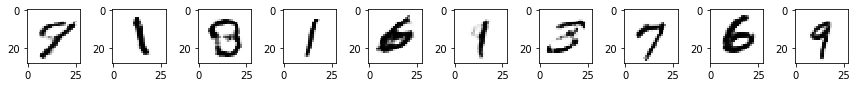

Epoch 161:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 162:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 163:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 164:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 165:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 166:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 167:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 168:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 169:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 170:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 171:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 172:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 173:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 174:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 175:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 176:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 177:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 178:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 179:   0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 180 ---------------


Epoch 180:   0%|          | 0/468 [00:00<?, ?it/s]

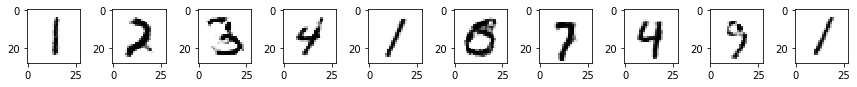

Epoch 181:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 182:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 183:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 184:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 185:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 186:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 187:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 188:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 189:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 190:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 191:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 192:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 193:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 194:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 195:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 196:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 197:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 198:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 199:   0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 200 ---------------


Epoch 200:   0%|          | 0/468 [00:00<?, ?it/s]

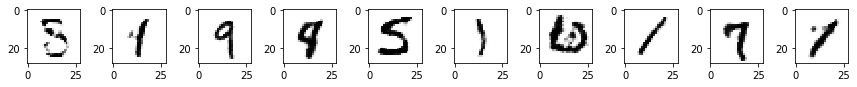

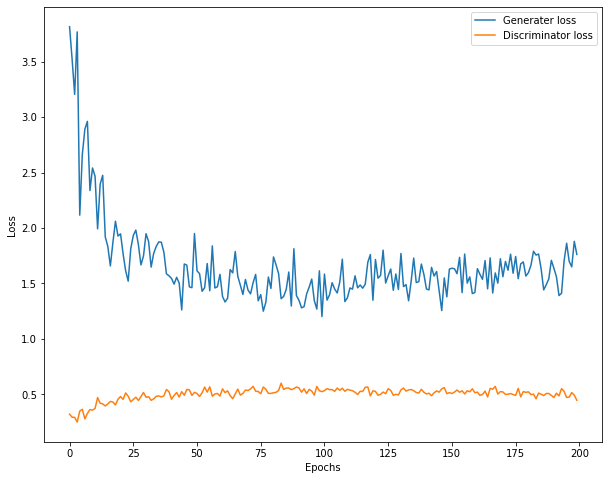

In [35]:
train(epochs = 200, plt_frq = 20, BATCH_SIZE = 128)

In [36]:
gan.save('mnist_GAN.h5')